In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from xgboost import XGBClassifier


# Loading the files

In [34]:
df_train = pd.read_csv('./datasets/train/train_text_seq.csv')
df_valid = pd.read_csv('./datasets/valid/valid_text_seq.csv')

# Extract input sequences and labels
X_train = df_train['input_str'].values
y_train = df_train['label'].values
X_valid = df_valid['input_str'].values
y_valid = df_valid['label'].values



# Preprocessing the data

In [35]:
# Encode the digits using LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(list('0123456789'))

# Convert input_str into sequences of encoded digits, removing the first three zeroes
def encode_sequence(sequence):
    return label_encoder.transform(list(sequence.lstrip('0')))  # Remove leading zeroes

X_train_encoded = [encode_sequence(seq) for seq in X_train]
X_valid_encoded = [encode_sequence(seq) for seq in X_valid]

# Pad the sequences to ensure they all have the same length (47 in this case)
X_train_padded = pad_sequences(X_train_encoded, maxlen=47, padding='post')
X_valid_padded = pad_sequences(X_valid_encoded, maxlen=47, padding='post')

# Convert the labels to categorical (0 or 1)
y_train_categorical = to_categorical(y_train, num_classes=2)
y_valid_categorical = to_categorical(y_valid, num_classes=2)

# Experimentation with different models

In [36]:
#apply logistic regression to the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression()
logreg.fit(X_train_padded, y_train)
y_pred = logreg.predict(X_valid_padded)
print("Accuracy:", accuracy_score(y_valid, y_pred))

Accuracy: 0.5030674846625767


In [37]:
#apply random forest classification on the data
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_padded, y_train)
y_pred = rf.predict(X_valid_padded)
print("Accuracy:", accuracy_score(y_valid, y_pred))

Accuracy: 0.5787321063394683


In [38]:
#apply xgboost classification on the data after instaling xgboost
xgb = XGBClassifier()
xgb.fit(X_train_padded, y_train)
y_pred = xgb.predict(X_valid_padded)
print("Accuracy:", accuracy_score(y_valid, y_pred))


Accuracy: 0.6053169734151329


# Our Model - LSTM + CNN

In [39]:
total_samples = len(X_train_padded)
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_size_80_random = int(total_samples* 0.8)
X_train_80 = X_train_padded[:train_size_80_random]
y_train_80 = y_train_categorical[:train_size_80_random]
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=12, input_length=47))  # Embedding layer with output_dim=12
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Convolutional layer with 32 filters
model.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(LSTM(24, return_sequences=False))  # LSTM layer with 24 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train_categorical, 
          validation_data=(X_valid_padded, y_valid_categorical), 
          epochs=150, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_valid_padded, y_valid_categorical)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

Epoch 1/150


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5036 - loss: 0.6934 - val_accuracy: 0.5153 - val_loss: 0.6904
Epoch 2/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5623 - loss: 0.6811 - val_accuracy: 0.6728 - val_loss: 0.6239
Epoch 3/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6435 - loss: 0.6327 - val_accuracy: 0.6871 - val_loss: 0.5825
Epoch 4/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 0.5974 - val_accuracy: 0.7137 - val_loss: 0.5529
Epoch 5/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7035 - loss: 0.5648 - val_accuracy: 0.7485 - val_loss: 0.5163
Epoch 6/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7231 - loss: 0.5411 - val_accuracy: 0.7587 - val_loss: 0.5110
Epoch 7/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7251 - loss: 0.5440 - val_accuracy: 0.7730 - val_loss: 0.4855
Epoch 8/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7498 - loss: 0.5120 - val_accuracy: 0.7914

In [40]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 47, 12)         │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 45, 32)         │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 22, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 24)             │         5,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,928 (89.57 KB)

 Trainable params: 7,642 (29.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,286 (59.71 KB)

In [41]:
model.save('./models/dataset3.keras')

# Using 80%, 60%, 40%, 20% of dataset to train

Model using 80% of dataset

In [42]:
total_samples = len(X_train_padded)
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_size_80_random = int(total_samples* 0.8)
X_train_80 = X_train_padded[:train_size_80_random]
y_train_80 = y_train_categorical[:train_size_80_random]
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=12, input_length=47))  # Embedding layer with output_dim=12
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Convolutional layer with 32 filters
model.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(LSTM(24, return_sequences=False))  # LSTM layer with 24 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_80, y_train_80, 
          validation_data=(X_valid_padded, y_valid_categorical), 
          epochs=150, batch_size=32)

# Evaluate the model
loss, accuracy80 = model.evaluate(X_valid_padded, y_valid_categorical)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy80}')

Epoch 1/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4981 - loss: 0.6939 - val_accuracy: 0.5174 - val_loss: 0.6916
Epoch 2/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5497 - loss: 0.6843 - val_accuracy: 0.6524 - val_loss: 0.6301
Epoch 3/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6273 - loss: 0.6390 - val_accuracy: 0.6871 - val_loss: 0.6120
Epoch 4/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6363 - loss: 0.6337 - val_accuracy: 0.6892 - val_loss: 0.5940
Epoch 5/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6681 - loss: 0.6117 - val_accuracy: 0.7137 - val_loss: 0.5786
Epoch 6/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6837 - loss: 0.5918 - val_accuracy: 0.7198 - val_loss: 0.5620
Epoch 7/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6954 - loss: 0.5728 - val_accuracy: 0.7301 - val_loss: 0.5567
Epoch 8/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7138 - loss: 0.5583 - val_accu

Model using 60% of dataset

In [43]:
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_size_60_random = int(total_samples* 0.6)
X_train_60 = X_train_padded[:train_size_60_random]
y_train_60 = y_train_categorical[:train_size_60_random]
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=12, input_length=47))  # Embedding layer with output_dim=12
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Convolutional layer with 32 filters
model.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(LSTM(24, return_sequences=False))  # LSTM layer with 24 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_60, y_train_60, 
          validation_data=(X_valid_padded, y_valid_categorical), 
          epochs=150, batch_size=32)

# Evaluate the model
loss, accuracy60 = model.evaluate(X_valid_padded, y_valid_categorical)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy60}')

Epoch 1/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4998 - loss: 0.6936 - val_accuracy: 0.5174 - val_loss: 0.6917
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5380 - loss: 0.6911 - val_accuracy: 0.6769 - val_loss: 0.6367
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6130 - loss: 0.6516 - val_accuracy: 0.6769 - val_loss: 0.6135
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6498 - loss: 0.6339 - val_accuracy: 0.7014 - val_loss: 0.6010
Epoch 5/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6578 - loss: 0.6147 - val_accuracy: 0.6953 - val_loss: 0.5945
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 0.6067 - val_accuracy: 0.7178 - val_loss: 0.5625
Epoch 7/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6925 - loss: 0.5904 - val_accuracy: 0.7342 - val_loss: 0.5545
Epoch 8/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 0.5698 - val_accu

Model using 40% of dataset

In [44]:
total_samples = len(X_train_padded)
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_size_40_random = int(total_samples* 0.4)
X_train_40 = X_train_padded[:train_size_40_random]
y_train_40 = y_train_categorical[:train_size_40_random]
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=12, input_length=47))  # Embedding layer with output_dim=12
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Convolutional layer with 32 filters
model.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(LSTM(24, return_sequences=False))  # LSTM layer with 24 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_40, y_train_40, 
          validation_data=(X_valid_padded, y_valid_categorical), 
          epochs=150, batch_size=32)

# Evaluate the model
loss, accuracy40 = model.evaluate(X_valid_padded, y_valid_categorical)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy40}')

Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4979 - loss: 0.6934 - val_accuracy: 0.5153 - val_loss: 0.6918
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5157 - loss: 0.6910 - val_accuracy: 0.4867 - val_loss: 0.6955
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 0.6703 - val_accuracy: 0.6339 - val_loss: 0.6355
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6251 - loss: 0.6384 - val_accuracy: 0.6728 - val_loss: 0.6120
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6495 - loss: 0.6246 - val_accuracy: 0.6667 - val_loss: 0.6037
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6716 - loss: 0.6022 - val_accuracy: 0.6789 - val_loss: 0.6002
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6711 - loss: 0.5971 - val_accuracy: 0.6871 - val_loss: 0.5836
Epoch 8/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6834 - loss: 0.5840 - val_accuracy: 0.7137 - v

Model using 20% of dataset

In [45]:
total_samples = len(X_train_padded)
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_size_20_random = int(total_samples* 0.2)
X_train_20 = X_train_padded[:train_size_20_random]
y_train_20 = y_train_categorical[:train_size_20_random]
model = Sequential()
model.add(Embedding(input_dim=10, output_dim=12, input_length=47))  # Embedding layer with output_dim=12
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))  # Convolutional layer with 32 filters
model.add(MaxPooling1D(pool_size=2))  # Max pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(LSTM(24, return_sequences=False))  # LSTM layer with 24 units
model.add(Dense(32, activation='relu'))  # Dense layer with 32 units
model.add(Dense(2, activation='softmax'))  # Output layer for binary classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_20, y_train_20, 
          validation_data=(X_valid_padded, y_valid_categorical), 
          epochs=150, batch_size=32)

# Evaluate the model
loss, accuracy20 = model.evaluate(X_valid_padded, y_valid_categorical)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy20}')

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4747 - loss: 0.6936 - val_accuracy: 0.5112 - val_loss: 0.6931
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5080 - loss: 0.6932 - val_accuracy: 0.5153 - val_loss: 0.6928
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4740 - loss: 0.6933 - val_accuracy: 0.5153 - val_loss: 0.6927
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.5235 - val_loss: 0.6927
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5004 - loss: 0.6930 - val_accuracy: 0.5256 - val_loss: 0.6920
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5088 - loss: 0.6933 - val_accuracy: 0.5317 - val_loss: 0.6904
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5346 - loss: 0.6899 - val_accuracy: 0.5971 - val_loss: 0.6668
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6127 - loss: 0.6604 - val_accuracy: 0.6503 - v

In [46]:
import matplotlib as mtpl
from matplotlib import pyplot as plt

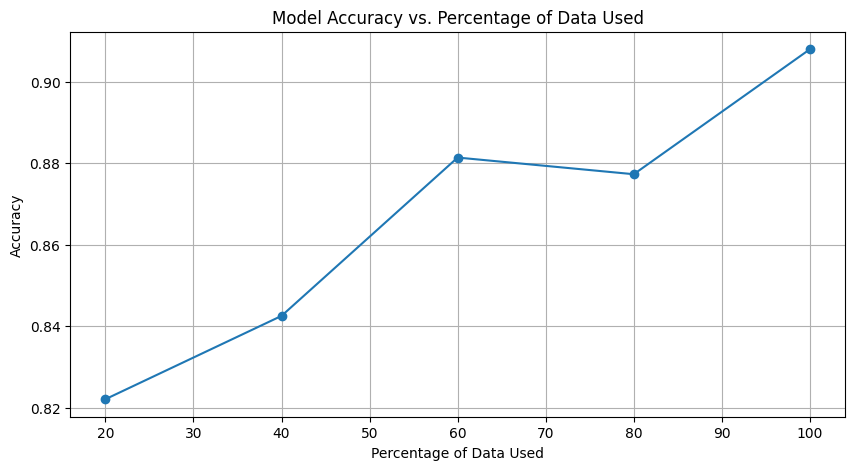

In [47]:
import matplotlib.pyplot as plt

# Percentages of data used
percentages = [100, 80, 60, 40, 20]

# Accuracies corresponding to the percentages 

accuracies = [accuracy,accuracy80,accuracy60,accuracy40,accuracy20]

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(percentages, accuracies, marker='o')
plt.title('Model Accuracy vs. Percentage of Data Used')
plt.xlabel('Percentage of Data Used')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()